<a href="https://colab.research.google.com/github/mengyaoo/FNL_GenesSelection/blob/main/11_TC1_Cluster_PCA%26tSNE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load the libraries

In [97]:
from __future__ import print_function

import os, sys, gzip, glob, json, time, argparse
import pandas as pd
import numpy as np
import keras
from pandas.io.json import json_normalize

from pandas.io.json import json_normalize
from keras.utils import to_categorical
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from keras.utils import to_categorical
from keras import backend as K
from keras.layers import Input, Dense, Dropout, Activation, Conv1D, MaxPooling1D, Flatten
from keras import optimizers
from keras.optimizers import SGD, Adam, RMSprop
from keras.models import Sequential, Model, model_from_json, model_from_yaml
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau

from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import sklearn.manifold as sk_manif
from keras.models import model_from_json
from keras.utils import to_categorical

import matplotlib.pyplot as plt
%matplotlib inline

# Data Preparation   

In [98]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [99]:
# Read features and output files 
TC1data15 = pd.read_csv("/content/drive/My Drive/FNL_TC1/TC1-S1-data15-genename.tsv", sep="\t", low_memory = False)
#TC1data15 = sfeatures1
TC1data15

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,STPG1,NIPAL3,LAS1L,ENPP4,SEMA3F,CFTR,ANKIB1,CYP51A1,KRIT1,RAD52,MYH16,BAD,LAP3,CD99,HS3ST1,AOC1,WNT16,HECW1,MAD1L1,LASP1,SNX11,TMEM176A,M6PR,KLHL13,CYP26B1,ICA1,DBNDD1,ALS2,CASP10,CFLAR,...,PLCXD1.1,WASH6P.1,WASIR1.1,IL3RA.1,SHOX.1,ASMT.1,AKAP17A.1,CSF2RA.1,CRLF2.1,ZBED1.1,RNA5SP498.1,TRPC6P.1,RP13-297E16.4.1,DHRSX-IT1.1,CD99P1.1,RPL14P5.1,LINC00685.1,DDX11L16.1,TCEB1P24.1,LL0YNC03-29C1.1.1,KRT18P53.1,LINC00102.1,RP13-297E16.5.1,FABP5P13.1,ASMTL-AS1.1,LINC00106.1,DPH3P2.1,RP11-309M23.1.1,AMDP1.1,BX649553.1.1,BX649553.2.1,BX649553.3.1,BX649553.4.1,MIR3690.1,AJ271736.10.1,Metazoa_SRP.305,AJ271736.1.1,MIR6089.1,RP13-465B17.5.1,RP13-465B17.4.1
0,1.829525,0.000000,2.062846,0.913543,0.809255,0.365063,1.315347,1.936558,0.657487,1.437908,0.551174,0.719120,1.393872,1.118917,1.987483,0.000000,1.393437,0.257243,1.161696,1.141140,0.0,1.644513,1.765476,2.090856,0.549029,0.718534,0.0,0.0,0.750320,1.912752,1.141035,1.480509,1.567273,0.164270,0.101726,1.313405,1.158674,1.141063,0.798311,1.360485,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.541309,0.000000,1.815986,0.593689,0.557331,0.608742,1.376983,1.592561,0.569209,1.103958,0.478385,1.033488,1.008026,0.758012,1.681421,1.453353,1.018066,0.223281,0.788680,0.693349,0.0,2.098755,1.643610,2.391891,0.884490,0.000000,0.0,0.0,1.128794,1.836294,0.778508,1.743826,1.415378,0.000000,0.173718,0.749825,1.539502,0.676204,0.761320,0.964733,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.282789,0.000000,1.895928,0.571531,0.332523,0.576545,1.171834,1.351888,0.836259,1.423673,0.200690,0.874702,0.876875,0.904634,1.109651,0.617534,0.904555,0.000000,0.724887,0.834916,0.0,1.567345,1.350662,2.029576,0.246144,2.193634,0.0,0.0,0.820252,1.581194,0.813868,1.547321,1.086540,0.000000,0.000000,0.464639,1.080810,0.456927,0.652686,0.725820,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.388260,0.000000,1.905475,0.399374,0.259750,0.219200,0.494936,1.822393,0.619865,0.793788,0.221321,0.567275,1.334915,0.984844,1.915951,0.458862,0.611663,0.000000,0.341496,0.735198,0.0,1.955291,1.635719,2.151499,0.000000,1.956215,0.0,0.0,0.867816,1.938688,1.049283,2.416171,1.523516,0.000000,0.000000,0.663285,0.998184,0.468721,0.456932,0.606861,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.389160,0.530588,2.316735,0.349455,0.189075,0.623428,0.801534,1.685248,0.784901,0.922292,0.489743,0.968513,1.126255,0.844110,0.942073,0.000000,0.995927,0.169634,0.783794,0.614325,0.0,2.429317,1.840638,2.187733,0.238939,1.196076,0.0,0.0,1.040287,1.824699,0.927491,1.818541,1.317428,0.000000,0.000000,1.098857,1.070776,0.503460,0.218645,0.819567,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,1.897300,0.000000,1.829995,0.656801,0.001333,0.528604,2.618544,1.993496,1.487510,1.049062,0.000000,0.258848,1.455348,0.853410,1.215961,0.000000,0.571925,0.644190,0.536399,0.215012,0.0,1.704930,2.033992,2.059344,0.000000,0.000000,0.0,0.0,0.811806,1.861269,1.084387,2.724172,1.159409,0.000000,0.000000,0.193960,1.282674,0.685311,0.463778,0.899169,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [100]:
outcome = pd.read_csv('/content/drive/My Drive/FNL_TC1/TC1-outcome-data15-projectname.tsv', sep='\t')
outcome

,Project_id_name,Project_id
0,TCGA-OV,10
1,TCGA-OV,10
2,TCGA-OV,10
3,TCGA-OV,10
4,TCGA-OV,10
...,...,...
4495,TCGA-LIHC,7
4496,TCGA-LIHC,7
4497,TCGA-LIHC,7
4498,TCGA-LIHC,7


In [101]:
TC1data15['project_id_name'] = outcome['Project_id_name']
TC1data15['project_id'] = outcome['Project_id']

TC1data15_cluster = TC1data15.copy()
TC1data15_cluster['project_id_name'] = TC1data15_cluster['project_id_name'].replace(['TCGA-CESC','TCGA-LUSC','TCGA-BLCA','TCGA-HNSC'],'SCC')
TC1data15_cluster['project_id'] = TC1data15_cluster['project_id'].replace([0,2,4,9],0)

cluster_300 = TC1data15_cluster[(TC1data15_cluster['project_id_name'] == 'SCC')].copy().sample(n = 300)
TC1data15_reduced = TC1data15_cluster[(TC1data15_cluster['project_id_name'] != 'SCC')].copy()
TC1data15_reduced = TC1data15_reduced.append(cluster_300)

TC1data15_reduced['project_id'] = TC1data15_reduced['project_id'].replace([13],2)
TC1data15_reduced['project_id'] = TC1data15_reduced['project_id'].replace([14],4)
TC1data15_reduced['project_id'] = TC1data15_reduced['project_id'].replace([15],9)
TC1data15 = TC1data15_reduced.copy()

outcome = TC1data15.loc[:,['project_id','project_id_name']]
TC1data15 = TC1data15.iloc[:,:-2]

TC1data15.shape, outcome.shape

((3600, 60483), (3600, 2))

In [102]:
#outcome = outcome.values
#outcome = outcome['Project_id_name']

In [103]:
def encode(data): 
    print('Shape of data (BEFORE encode): %s' % str(data.shape))
    encoded = to_categorical(data)
    print('Shape of data (AFTER  encode): %s\n' % str(encoded.shape))
    return encoded



# ConvNN(PCA) - Top150

In [104]:
outcome = encode(outcome['project_id'])
# outcome = np.expand_dims(outcome, axis=2)
# outcome[0].value_counts()

Shape of data (BEFORE encode): (3600,)
Shape of data (AFTER  encode): (3600, 13)



## Train/Test split    

In [105]:
TC1data15_selected = TC1data15.loc[:,sum_loading.sort_values(ascending=False)[:150].index]

In [106]:
X_train, X_test, Y_train, Y_test = train_test_split(TC1data15_selected, 
                                                    outcome, 
                                                    train_size=0.75, 
                                                    test_size=0.25, 
                                                    random_state=123, 
                                                    stratify = outcome)

## CONV1D 

In [107]:
# parameters  
activation='relu'
batch_size=20
# Number of sites
classes=13
drop = 0.1
feature_subsample = 0
loss='categorical_crossentropy'
# metrics='accuracy'
out_act='softmax'
pool=[1, 10]
# optimizer='sgd'
shuffle = False 
epochs=30

optimizer = optimizers.SGD(lr=0.1)
metrics = ['acc']

In [108]:
np.expand_dims(X_train, axis=2).shape

(2700, 150, 1)

In [109]:
# X_train shape: (3375, 1883)
# X_test shape:  (1125, 1883)
# Y_train shape: (3375,15)
# Y_test shape:  (1125,15)

# 1883
x_train_len = X_train.shape[1]   

X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

# X_train shape: (3375, 1883, 1)
# X_test shape:  (1125, 1883, 1)

filters = 128 
filter_len = 20 
stride = 1 

# inside pool_list loop
pool_list = [1,10]

K.clear_session()

model = Sequential()

# model.add  CONV1D
model.add(Conv1D(filters = filters, 
                 kernel_size = filter_len, 
                 strides = stride, 
                 padding='valid', 
                 input_shape=(x_train_len, 1)))

# x_train_len = 60,483
# Activation
model.add(Activation('relu'))

# MaxPooling
model.add(MaxPooling1D(pool_size = 1))

filters = 128
filter_len = 10 
stride = 1 
# Conv1D
model.add(Conv1D(filters=filters, 
                 kernel_size=filter_len, 
                 strides=stride, 
                 padding='valid'))
# Activation
model.add(Activation('relu'))

# MaxPooling
model.add(MaxPooling1D(pool_size = 10))
model.add(Flatten())

model.add(Dense(200))

# activation 
# model.add(Activation('relu')) # SR
model.add(Activation(activation))
#dropout
model.add(Dropout(0.1))

model.add(Dense(20))
# activation
# model.add(Activation('relu')) # SR
model.add(Activation(activation))

#dropout
model.add(Dropout(0.1))

model.add(Dense(13))
model.add(Activation(out_act))

model.compile( loss= loss, 
              optimizer = optimizer, 
              metrics = metrics )
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 131, 128)          2688      
_________________________________________________________________
activation (Activation)      (None, 131, 128)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 131, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 122, 128)          163968    
_________________________________________________________________
activation_1 (Activation)    (None, 122, 128)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 12, 128)           0         
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0

In [110]:
# save
save = '.'
output_dir = "/content/drive/My Drive/FNL_TC1/Model"

if not os.path.exists(output_dir):
        os.makedirs(output_dir)

model_name = 'tc1_pca129'
path = '{}/{}.autosave.model.h5'.format(output_dir, model_name)
checkpointer = ModelCheckpoint(filepath=path,
                               verbose=1,
                               save_weights_only=True,
                               save_best_only=True)

csv_logger = CSVLogger('{}/training.log'.format(output_dir))

In [111]:
# SR: change epsilon to min_delta
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1, 
                              patience=10, 
                              verbose=1, mode='auto', 
                              min_delta=0.0001, 
                              cooldown=0, 
                              min_lr=0)

In [112]:
# batch_size = 20 
history = model.fit(X_train, Y_train, batch_size=batch_size, 
                    epochs=epochs, verbose=1, validation_data=(X_test, Y_test), 
                    callbacks = [checkpointer, csv_logger, reduce_lr])

score = model.evaluate(X_test, Y_test, verbose=0)

Epoch 1/30
135/135 [==============================] - 7s 50ms/step - loss: 2.1313 - acc: 0.2774 - val_loss: 0.5001 - val_acc: 0.8744

Epoch 00001: val_loss improved from inf to 0.50009, saving model to /content/drive/My Drive/FNL_TC1/Model/tc1_pca129.autosave.model.h5
Epoch 2/30
135/135 [==============================] - 6s 46ms/step - loss: 0.4957 - acc: 0.8392 - val_loss: 0.2295 - val_acc: 0.9233

Epoch 00002: val_loss improved from 0.50009 to 0.22946, saving model to /content/drive/My Drive/FNL_TC1/Model/tc1_pca129.autosave.model.h5
Epoch 3/30
135/135 [==============================] - 6s 46ms/step - loss: 0.2190 - acc: 0.9324 - val_loss: 0.1895 - val_acc: 0.9500

Epoch 00003: val_loss improved from 0.22946 to 0.18952, saving model to /content/drive/My Drive/FNL_TC1/Model/tc1_pca129.autosave.model.h5
Epoch 4/30
135/135 [==============================] - 6s 46ms/step - loss: 0.1125 - acc: 0.9659 - val_loss: 0.2343 - val_acc: 0.9333

Epoch 00004: val_loss did not improve from 0.18952


In [113]:
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.16680830717086792
Test accuracy: 0.9622222185134888


Text(0.5, 0, 'epoch')

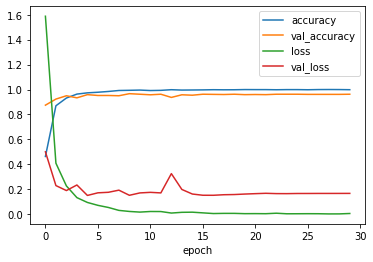

In [114]:
plt.plot(history.history['acc'],label="accuracy")
plt.plot(history.history['val_acc'],label="val_accuracy")
plt.plot(history.history['loss'],label="loss")
plt.plot(history.history['val_loss'],label="val_loss")
plt.legend()
plt.xlabel('epoch')

## Save the model/weights

In [115]:
# JSON JSON
# serialize model to json
json_model = model.to_json()

# save the model architecture to JSON file
with open('{}/{}.model.json'.format(output_dir, model_name), 'w') as json_file:
    json_file.write(json_model)


# YAML YAML
# serialize model to YAML
model_yaml = model.to_yaml()

# save the model architecture to YAML file
with open("{}/{}.model.yaml".format(output_dir, model_name), "w") as yaml_file:
    yaml_file.write(model_yaml)


# WEIGHTS HDF5
# serialize weights to HDF5
model.save_weights("{}/{}.model.h5".format(output_dir,model_name))
print("Saved model to disk")

Saved model to disk


In [116]:
# Open the handle
json_file = open('{}/{}.model.json'.format(output_dir, model_name), 'r')

# load json and create model
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights('{}/{}.model.h5'.format(output_dir, model_name))
print("Loaded model from disk")
# loaded_model_json

Loaded model from disk


In [117]:
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='sgd', 
                     metrics=['accuracy'])
score = loaded_model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))


Test score: 0.16680830717086792
Test accuracy: 0.9622222185134888
accuracy: 96.22%


# ConvNN(PCA) - top 300

## Train/Test split    

In [118]:
# from keras.utils import to_categorical
# outcome = encode(outcome['Project_id'])

In [119]:
TC1data15_selected = TC1data15.loc[:,sum_loading.sort_values(ascending=False)[:300].index]

In [120]:
X_train, X_test, Y_train, Y_test = train_test_split(TC1data15_selected, 
                                                    outcome, 
                                                    train_size=0.75, 
                                                    test_size=0.25, 
                                                    random_state=123, 
                                                    stratify = outcome)

In [121]:
X_train

,MTND4P12,COX6CP1,MINOS1P3,H19,COX20P1,LTF,PLA2G2A,CST1,ERAP2,RPS28P7,HCG4P5,NLRP2,OLFM4,SST,MTRNR2L1,RP11-109M17.2,GSTM1,PIGR,NTS,IGLV8-61,IGHD,IGF2,EEF1A2,PRSS21,DEFB1,MSLN,CXCL5,CXCL14,MSMB,IGLV10-54,MTND1P23,RP11-467L13.5,C1DP1,IGLV4-60,CD177,BEX1,PCDHB5,PEG10,REG1A,PCSK1N,...,IGLV3-19,C2orf54,AP000351.3,SLITRK6,EPHX3,SPON1,GAL,CLDN2,NUPR1L,BPIFB2,IGLV5-37,ALDH1A1,SOSTDC1,UCHL1,SOX2,IGHA2,KRT20,CYP24A1,MAOB,SIX2,GLDC,CNTFR,AGR3,IGLV1-36,EDN2,C1QL1,IGHV4-39,AREG,ERP27,HOXC10,CYP4F11,PALM3,CASC9,ALB,MAGEA4,HS6ST2,PDZK1IP1,FABP6,RNU4-2,KRT6A
78,1.630203,0.245745,0.617475,1.531048,0.217401,0.151195,1.115843,0.000000,0.270616,2.456450,1.540806,1.604526,0.000000,3.007129,0.539980,1.672453,1.648313,0.848560,0.477534,1.559609,0.254776,1.392720,0.000000,0.259556,2.906409,2.674018,0.000000,2.016438,0.000000,0.061648,1.948268,0.997439,0.000000,0.106625,0.000000,0.192577,0.871038,1.590481,0.000000,1.511048,...,3.141406,0.927782,0.000000,0.000000,0.000000,2.136099,0.000000,0.000000,1.732365,0.0,0.000000,1.261969,0.000000,1.772130,1.053052,1.571418,0.000000,0.000000,0.704472,0.305838,0.581240,0.511640,0.249679,0.108730,0.755715,0.275099,2.402433,0.591675,1.439627,0.000000,1.004386,1.454823,0.000000,0.156108,0.000000,0.000000,2.108844,1.291987,3.052099,0.906333
1425,0.913352,1.187209,1.191948,0.555510,0.101678,0.197502,0.000000,0.000000,0.837544,2.730934,1.052432,0.000000,0.000000,0.000000,0.000000,0.000000,1.726351,1.403615,1.051820,2.120729,0.853222,0.000000,0.000000,1.094274,2.055905,1.146227,1.219891,2.955669,0.000000,1.038178,0.648074,0.117067,0.000000,0.220576,0.402360,0.000000,0.686118,0.876908,3.009419,0.875238,...,2.119397,0.000000,0.867344,0.000000,0.000000,0.000000,0.000000,2.253958,0.000000,0.0,0.000000,2.842135,0.000000,1.331460,0.000000,2.281293,0.000000,0.000000,2.259375,0.000000,0.835548,0.000000,0.000000,0.643530,0.524939,1.713803,2.174148,1.037635,1.146442,1.267564,0.721462,1.437761,0.546841,0.793268,0.000000,0.000000,2.990324,2.307448,0.329036,0.000000
3589,2.220811,0.000000,0.000000,2.682109,0.000000,0.046970,1.167290,0.292887,0.507182,3.079196,0.818919,0.000000,0.000000,0.000000,0.000000,0.961562,1.040686,0.743894,0.000000,0.164106,0.000000,1.330595,2.815335,1.581307,2.238399,2.180905,0.000000,2.355650,0.842468,0.000000,0.386654,0.000000,0.000000,0.000000,0.184625,0.000000,0.038657,0.000000,0.000000,0.000000,...,1.028673,1.127188,0.000000,0.000000,2.246907,1.109462,0.211231,0.000000,0.000000,0.0,0.000000,1.696248,0.000000,1.462865,1.919780,0.865260,0.000000,1.326671,0.849403,0.940579,0.204173,0.359708,0.000000,0.000000,0.000000,0.543897,0.930868,1.722511,0.000000,0.000000,0.761585,0.000000,1.822418,0.000000,0.749791,1.436924,2.065042,0.850816,0.000000,3.609317
3076,2.145148,0.000000,0.741737,0.293831,0.000000,0.231487,0.000000,0.000000,1.559480,3.247094,1.450892,1.563270,0.000000,0.000000,0.000000,0.000000,0.000000,0.534762,0.000000,1.485607,1.713526,0.350373,0.064323,0.000000,0.523034,0.764995,0.350342,2.994062,0.000000,1.199072,0.478690,0.000000,1.387969,0.719004,1.892532,1.264773,0.269078,1.413557,0.000000,1.137254,...,1.535040,0.115746,0.913475,0.000000,0.795731,0.324460,0.000000,1.126812,1.263876,0.0,0.340142,2.059237,0.000000,1.008338,0.000000,2.196203,0.000000,1.451725,0.531147,0.000000,0.000000,0.000000,0.000000,0.596170,0.000000,1.473813,1.781845,1.872300,1.529948,0.000000,1.204500,1.837543,0.000000,0.000000,0.000000,0.482656,2.285589,0.000000,0.439283,0.744030
2536,2.424581,0.000000,0.000000,1.597254,0.000000,0.000000,0.000000,0.000000,1.483586,2.980569,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.404005,0.000000,0.000000,0.407930,0.920673,1.255731,0.000000,0.000000,0.000000,0.000000,0.000000,2.008415,0.000000,0.379663,1.571226,0.000000,0.000000,0.000000,0.000000,0.005442,0.000000,0.000000,0.000000,2.881680,...,0.730314,0.000000,1.062392,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,2.273454,0.000000,2.433383,0.000000,1.864628,0.000000,0.000000,1.767294,0.000000,0.000000,1.79

## CONV1D 

In [122]:
# parameters  
activation='relu'
batch_size=20
# Number of sites
classes=13
drop = 0.1
feature_subsample = 0
loss='categorical_crossentropy'
# metrics='accuracy'
out_act='softmax'
pool=[1, 10]
# optimizer='sgd'
shuffle = False 
epochs=30

optimizer = optimizers.SGD(lr=0.1)
metrics = ['acc']

In [123]:
# X_train shape: (3375, 300)
# X_test shape:  (1125, 300)
# Y_train shape: (3375,15)
# Y_test shape:  (1125,15)

# 300
x_train_len = X_train.shape[1]   

X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

# X_train shape: (3375, 300, 1)
# X_test shape:  (1125, 300, 1)

filters = 128 
filter_len = 20 
stride = 1 

# inside pool_list loop
pool_list = [1,10]

K.clear_session()

In [124]:
model = Sequential()

# model.add  CONV1D
model.add(Conv1D(filters = filters, 
                 kernel_size = filter_len, 
                 strides = stride, 
                 padding='valid', 
                 input_shape=(x_train_len, 1)))

# x_train_len = 300
# Activation
model.add(Activation('relu'))

# MaxPooling
model.add(MaxPooling1D(pool_size = 1))

filters = 128
filter_len = 10 
stride = 1 
# Conv1D
model.add(Conv1D(filters=filters, 
                 kernel_size=filter_len, 
                 strides=stride, 
                 padding='valid'))
# Activation
model.add(Activation('relu'))

# MaxPooling
model.add(MaxPooling1D(pool_size = 10))
model.add(Flatten())

model.add(Dense(200))

# activation 
# model.add(Activation('relu')) # SR
model.add(Activation(activation))
#dropout
model.add(Dropout(0.1))

model.add(Dense(20))
# activation
# model.add(Activation('relu')) # SR
model.add(Activation(activation))

#dropout
model.add(Dropout(0.1))

model.add(Dense(13))
model.add(Activation(out_act))

model.compile( loss= loss, 
              optimizer = optimizer, 
              metrics = metrics )
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 281, 128)          2688      
_________________________________________________________________
activation (Activation)      (None, 281, 128)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 281, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 272, 128)          163968    
_________________________________________________________________
activation_1 (Activation)    (None, 272, 128)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 27, 128)           0         
_________________________________________________________________
flatten (Flatten)            (None, 3456)              0

In [125]:
# save
# save = '/content/drive/My Drive/FNL_TC1/'
output_dir = "/content/drive/My Drive/FNL_TC1/Model"

if not os.path.exists(output_dir):
        os.makedirs(output_dir)

model_name = 'tc1_pca300'
path = '{}/{}.autosave.model.h5'.format(output_dir, model_name)
checkpointer = ModelCheckpoint(filepath=path,
                               verbose=1,
                               save_weights_only=True,
                               save_best_only=True)

csv_logger = CSVLogger('{}/training.log'.format(output_dir))

In [126]:
# SR: change epsilon to min_delta
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1, 
                              patience=10, 
                              verbose=1, mode='auto', 
                              min_delta=0.0001, 
                              cooldown=0, 
                              min_lr=0)

In [127]:
# batch_size = 20 
history = model.fit(X_train, Y_train, batch_size=batch_size, 
                    epochs=epochs, verbose=1, validation_data=(X_test, Y_test), 
                    callbacks = [checkpointer, csv_logger, reduce_lr])

score = model.evaluate(X_test, Y_test, verbose=0)

Epoch 1/30
135/135 [==============================] - 12s 85ms/step - loss: 2.1330 - acc: 0.2719 - val_loss: 0.2158 - val_acc: 0.9478

Epoch 00001: val_loss improved from inf to 0.21584, saving model to /content/drive/My Drive/FNL_TC1/Model/tc1_pca300.autosave.model.h5
Epoch 2/30
135/135 [==============================] - 11s 83ms/step - loss: 0.3260 - acc: 0.8948 - val_loss: 0.2163 - val_acc: 0.9389

Epoch 00002: val_loss did not improve from 0.21584
Epoch 3/30
135/135 [==============================] - 11s 83ms/step - loss: 0.1145 - acc: 0.9678 - val_loss: 0.1540 - val_acc: 0.9544

Epoch 00003: val_loss improved from 0.21584 to 0.15396, saving model to /content/drive/My Drive/FNL_TC1/Model/tc1_pca300.autosave.model.h5
Epoch 4/30
135/135 [==============================] - 11s 83ms/step - loss: 0.0620 - acc: 0.9851 - val_loss: 0.1094 - val_acc: 0.9656

Epoch 00004: val_loss improved from 0.15396 to 0.10936, saving model to /content/drive/My Drive/FNL_TC1/Model/tc1_pca300.autosave.model

In [128]:
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.12903091311454773
Test accuracy: 0.9744444489479065


Text(0.5, 0, 'epoch')

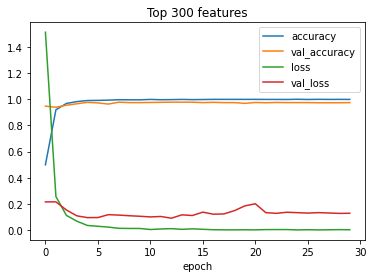

In [129]:
plt.plot(history.history['acc'],label="accuracy")
plt.plot(history.history['val_acc'],label="val_accuracy")
plt.plot(history.history['loss'],label="loss")
plt.plot(history.history['val_loss'],label="val_loss")
plt.legend()
plt.title("Top 300 features")
plt.xlabel('epoch')


## Save the model/weights

In [130]:
# JSON JSON
# serialize model to json
json_model = model.to_json()

# save the model architecture to JSON file
with open('{}/{}.model.json'.format(output_dir, model_name), 'w') as json_file:
    json_file.write(json_model)


# YAML YAML
# serialize model to YAML
model_yaml = model.to_yaml()

# save the model architecture to YAML file
with open("{}/{}.model.yaml".format(output_dir, model_name), "w") as yaml_file:
    yaml_file.write(model_yaml)


# WEIGHTS HDF5
# serialize weights to HDF5
model.save_weights("{}/{}.model.h5".format(output_dir,model_name))
print("Saved model to disk")

Saved model to disk


In [131]:
# Open the handle
json_file = open('{}/{}.model.json'.format(output_dir, model_name), 'r')

# load json and create model
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights('{}/{}.model.h5'.format(output_dir, model_name))
print("Loaded model from disk")
# loaded_model_json

Loaded model from disk


In [132]:
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='sgd', 
                     metrics=['accuracy'])
score = loaded_model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Test score: 0.12903091311454773
Test accuracy: 0.9744444489479065
accuracy: 97.44%


# ConvNN(PCA) - top 500

## Train/Test split    

In [133]:
# from keras.utils import to_categorical
# outcome = encode(outcome['Project_id'])

In [134]:
TC1data15_selected = TC1data15.loc[:,sum_loading.sort_values(ascending=False)[:500].index]

In [135]:
X_train, X_test, Y_train, Y_test = train_test_split(TC1data15_selected, 
                                                    outcome, 
                                                    train_size=0.75, 
                                                    test_size=0.25, 
                                                    random_state=123, 
                                                    stratify = outcome)

In [136]:
X_train

,MTND4P12,COX6CP1,MINOS1P3,H19,COX20P1,LTF,PLA2G2A,CST1,ERAP2,RPS28P7,HCG4P5,NLRP2,OLFM4,SST,MTRNR2L1,RP11-109M17.2,GSTM1,PIGR,NTS,IGLV8-61,IGHD,IGF2,EEF1A2,PRSS21,DEFB1,MSLN,CXCL5,CXCL14,MSMB,IGLV10-54,MTND1P23,RP11-467L13.5,C1DP1,IGLV4-60,CD177,BEX1,PCDHB5,PEG10,REG1A,PCSK1N,...,CMBL,SLC16A9,ADRA2C,MMP3,IGKV1-27,ALDOB,ZNF486,SFTPA2,RET,MAGEA3,CCL19,SPOCK1,KRT4,HPN,C16orf89,WFDC21P,COL17A1,ENPP3,AKR1C2,PVALB,KLK1,COL9A3,ABO,AC069213.1,MIR4768,IGHJ2,PTGES,HLA-DRB5,KLK14,DIO1,LINC01291,KIF1A,SCGN,CYP4B1,GJB2,ETV4,AKR1C3,MMP13,C7,RPS26P47
78,1.630203,0.245745,0.617475,1.531048,0.217401,0.151195,1.115843,0.000000,0.270616,2.456450,1.540806,1.604526,0.000000,3.007129,0.539980,1.672453,1.648313,0.848560,0.477534,1.559609,0.254776,1.392720,0.000000,0.259556,2.906409,2.674018,0.000000,2.016438,0.000000,0.061648,1.948268,0.997439,0.000000,0.106625,0.000000,0.192577,0.871038,1.590481,0.000000,1.511048,...,1.225151,0.779039,1.197374,0.000000,1.168982,0.000000,1.062244,0.000000,0.193099,0.000000,1.358832,0.472861,0.391652,1.782464,0.000000,0.665729,0.000000,0.000000,0.062490,1.045231,0.000000,0.000000,0.783736,0.000000,0.231831,0.000000,0.820319,2.458624,0.423180,0.036477,0.401121,0.792815,0.000000,1.180383,1.317328,1.260198,0.545236,1.281120,1.359645,0.908437
1425,0.913352,1.187209,1.191948,0.555510,0.101678,0.197502,0.000000,0.000000,0.837544,2.730934,1.052432,0.000000,0.000000,0.000000,0.000000,0.000000,1.726351,1.403615,1.051820,2.120729,0.853222,0.000000,0.000000,1.094274,2.055905,1.146227,1.219891,2.955669,0.000000,1.038178,0.648074,0.117067,0.000000,0.220576,0.402360,0.000000,0.686118,0.876908,3.009419,0.875238,...,2.159150,1.823950,0.747452,0.000000,1.461449,1.447322,1.290438,0.000000,0.000000,0.000000,0.000000,1.876827,0.000000,2.415055,0.000000,1.280801,0.926189,2.486943,0.803509,0.000000,0.000000,0.000000,1.063930,0.771459,0.000000,1.063281,0.881658,2.967778,0.000000,0.233882,0.000000,0.000000,0.967798,0.328345,2.090353,0.000000,1.810105,0.000000,0.413547,0.376008
3589,2.220811,0.000000,0.000000,2.682109,0.000000,0.046970,1.167290,0.292887,0.507182,3.079196,0.818919,0.000000,0.000000,0.000000,0.000000,0.961562,1.040686,0.743894,0.000000,0.164106,0.000000,1.330595,2.815335,1.581307,2.238399,2.180905,0.000000,2.355650,0.842468,0.000000,0.386654,0.000000,0.000000,0.000000,0.184625,0.000000,0.038657,0.000000,0.000000,0.000000,...,1.255080,0.055619,0.450027,1.667057,0.119861,0.000000,1.063639,0.000000,0.722241,1.862186,1.322049,1.030614,3.522314,0.511464,0.009834,1.254213,0.331735,0.000000,2.029226,0.000000,0.698625,0.211012,1.953720,1.114105,0.000000,0.000000,1.967658,2.039305,0.142991,0.000000,0.364465,0.000000,0.000000,1.035587,1.861667,1.265352,1.807911,0.822396,0.870495,0.000000
3076,2.145148,0.000000,0.741737,0.293831,0.000000,0.231487,0.000000,0.000000,1.559480,3.247094,1.450892,1.563270,0.000000,0.000000,0.000000,0.000000,0.000000,0.534762,0.000000,1.485607,1.713526,0.350373,0.064323,0.000000,0.523034,0.764995,0.350342,2.994062,0.000000,1.199072,0.478690,0.000000,1.387969,0.719004,1.892532,1.264773,0.269078,1.413557,0.000000,1.137254,...,1.274865,1.825101,0.531531,0.000000,1.047832,0.000000,1.938033,0.000000,0.580836,0.000000,0.345899,1.497002,0.000000,2.222316,2.019364,1.418039,1.392875,0.000000,0.000000,0.000000,0.621660,0.148880,1.728510,0.808624,0.000000,0.219287,0.959566,2.440548,0.000000,0.477342,0.457544,0.000000,0.000000,1.616714,0.924051,1.716899,0.625107,0.000000,1.408402,0.000000
2536,2.424581,0.000000,0.000000,1.597254,0.000000,0.000000,0.000000,0.000000,1.483586,2.980569,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.404005,0.000000,0.000000,0.407930,0.920673,1.255731,0.000000,0.000000,0.000000,0.000000,0.000000,2.008415,0.000000,0.379663,1.571226,0.000000,0.000000,0.000000,0.000000,0.005442,0.000000,0.000000,0.000000,2.881680,...,1.202617,0.003669,1.031663,0.000000,0.000000,0.834961,0.000000,0.000000,0.000000,0.000000,0.134509,0.057327,0.000000,0.003518,3.001422,0.265657,0.000000,0.000000,1.744613,0.4

## CONV1D 

In [137]:
# parameters  
activation='relu'
batch_size=20
# Number of sites
classes=15
drop = 0.1
feature_subsample = 0
loss='categorical_crossentropy'
# metrics='accuracy'
out_act='softmax'
pool=[1, 10]
# optimizer='sgd'
shuffle = False 
epochs=30

optimizer = optimizers.SGD(lr=0.1)
metrics = ['acc']

In [138]:
# X_train shape: (3375, 300)
# X_test shape:  (1125, 300)
# Y_train shape: (3375,15)
# Y_test shape:  (1125,15)

# 300
x_train_len = X_train.shape[1]   

X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

# X_train shape: (3375, 300, 1)
# X_test shape:  (1125, 300, 1)

filters = 128 
filter_len = 20 
stride = 1 

# inside pool_list loop
pool_list = [1,10]

K.clear_session()

In [139]:
model = Sequential()

# model.add  CONV1D
model.add(Conv1D(filters = filters, 
                 kernel_size = filter_len, 
                 strides = stride, 
                 padding='valid', 
                 input_shape=(x_train_len, 1)))

# x_train_len = 300
# Activation
model.add(Activation('relu'))

# MaxPooling
model.add(MaxPooling1D(pool_size = 1))

filters = 128
filter_len = 10 
stride = 1 
# Conv1D
model.add(Conv1D(filters=filters, 
                 kernel_size=filter_len, 
                 strides=stride, 
                 padding='valid'))
# Activation
model.add(Activation('relu'))

# MaxPooling
model.add(MaxPooling1D(pool_size = 10))
model.add(Flatten())

model.add(Dense(200))

# activation 
# model.add(Activation('relu')) # SR
model.add(Activation(activation))
#dropout
model.add(Dropout(0.1))

model.add(Dense(20))
# activation
# model.add(Activation('relu')) # SR
model.add(Activation(activation))

#dropout
model.add(Dropout(0.1))

model.add(Dense(13))
model.add(Activation(out_act))

model.compile( loss= loss, 
              optimizer = optimizer, 
              metrics = metrics )
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 481, 128)          2688      
_________________________________________________________________
activation (Activation)      (None, 481, 128)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 481, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 472, 128)          163968    
_________________________________________________________________
activation_1 (Activation)    (None, 472, 128)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 47, 128)           0         
_________________________________________________________________
flatten (Flatten)            (None, 6016)              0

In [140]:
# save
# save = '/content/drive/My Drive/FNL_TC1/'
output_dir = "/content/drive/My Drive/FNL_TC1/Model"

if not os.path.exists(output_dir):
        os.makedirs(output_dir)

model_name = 'tc1_pca518'
path = '{}/{}.autosave.model.h5'.format(output_dir, model_name)
checkpointer = ModelCheckpoint(filepath=path,
                               verbose=1,
                               save_weights_only=True,
                               save_best_only=True)

csv_logger = CSVLogger('{}/training.log'.format(output_dir))

In [141]:
# SR: change epsilon to min_delta
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1, 
                              patience=10, 
                              verbose=1, mode='auto', 
                              min_delta=0.0001, 
                              cooldown=0, 
                              min_lr=0)

In [142]:
# batch_size = 20 
history = model.fit(X_train, Y_train, batch_size=batch_size, 
                    epochs=epochs, verbose=1, validation_data=(X_test, Y_test), 
                    callbacks = [checkpointer, csv_logger, reduce_lr])

score = model.evaluate(X_test, Y_test, verbose=0)

Epoch 1/30
135/135 [==============================] - 19s 136ms/step - loss: 2.0970 - acc: 0.2836 - val_loss: 0.2946 - val_acc: 0.9333

Epoch 00001: val_loss improved from inf to 0.29455, saving model to /content/drive/My Drive/FNL_TC1/Model/tc1_pca518.autosave.model.h5
Epoch 2/30
135/135 [==============================] - 18s 132ms/step - loss: 0.2121 - acc: 0.9367 - val_loss: 0.1102 - val_acc: 0.9667

Epoch 00002: val_loss improved from 0.29455 to 0.11023, saving model to /content/drive/My Drive/FNL_TC1/Model/tc1_pca518.autosave.model.h5
Epoch 3/30
135/135 [==============================] - 18s 132ms/step - loss: 0.1141 - acc: 0.9680 - val_loss: 0.0823 - val_acc: 0.9744

Epoch 00003: val_loss improved from 0.11023 to 0.08230, saving model to /content/drive/My Drive/FNL_TC1/Model/tc1_pca518.autosave.model.h5
Epoch 4/30
135/135 [==============================] - 18s 132ms/step - loss: 0.0373 - acc: 0.9892 - val_loss: 0.0743 - val_acc: 0.9789

Epoch 00004: val_loss improved from 0.08230

In [143]:
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.0974946841597557
Test accuracy: 0.9844444394111633


Text(0.5, 0, 'epoch')

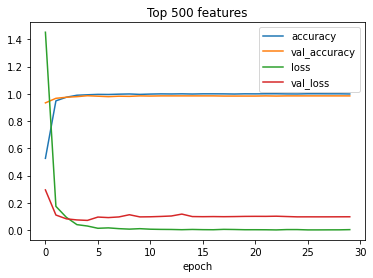

In [148]:
plt.plot(history.history['acc'],label="accuracy")
plt.plot(history.history['val_acc'],label="val_accuracy")
plt.plot(history.history['loss'],label="loss")
plt.plot(history.history['val_loss'],label="val_loss")
plt.legend()
plt.title("Top 500 features")
plt.xlabel('epoch')


## Save the model/weights

In [145]:
# JSON JSON
# serialize model to json
json_model = model.to_json()

# save the model architecture to JSON file
with open('{}/{}.model.json'.format(output_dir, model_name), 'w') as json_file:
    json_file.write(json_model)


# YAML YAML
# serialize model to YAML
model_yaml = model.to_yaml()

# save the model architecture to YAML file
with open("{}/{}.model.yaml".format(output_dir, model_name), "w") as yaml_file:
    yaml_file.write(model_yaml)


# WEIGHTS HDF5
# serialize weights to HDF5
model.save_weights("{}/{}.model.h5".format(output_dir,model_name))
print("Saved model to disk")

Saved model to disk


In [146]:
# Open the handle
json_file = open('{}/{}.model.json'.format(output_dir, model_name), 'r')

# load json and create model
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights('{}/{}.model.h5'.format(output_dir, model_name))
print("Loaded model from disk")
# loaded_model_json

Loaded model from disk


In [147]:
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='sgd', 
                     metrics=['accuracy'])
score = loaded_model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Test score: 0.0974946841597557
Test accuracy: 0.9844444394111633
accuracy: 98.44%
